In [15]:
import numpy as np
import sys
sys.path.append('../src')
import matplotlib.pyplot as plt
from coupler import *
from scipy import interpolate

# Theory 
The coupling coefficient of the 2x2 WDM (same fibre) is set for each mode as:


$$
k = \frac{\pi}{n_{eff} c} \frac{\int{\left(n(r)^2 - n_{0}(r) \right) \left| E (r)\right|^{2} dr}}{\int{\left|E(r)\right|^2  dr }} \cdot f \cdot L
$$
where f is the frequency and L the length of the fused stuff

In [18]:
lmin = 1530e-9
lmax = 1560e-9
N_l = 10
a = 5e-6
N_points = 1024
d_vec = np.linspace(0,10e-6,20)#1e-6
lp1 = 1549e-9
lp2 = 1555e-9
ls = 1550e-9



In [19]:
F = abs(c/ls - c/lp1)
fpc, fbs = c/lp2 + F, c/lp2 - F
lpc, lbs = c/fpc, c/fbs

In [20]:
couple_obj = Coupling_coefficients(lmin, lmax, N_l, a, N_points)
couple_obj.fibre_calculate()

Maximum V number in space is 3.2501674851661546


In [21]:
k01_vec, k11_vec, couple01_vec = [], [], []
for dd in d_vec:
    k01, k11, couple01, couple11 = couple_obj.create_coupling_coeff(dd)
    k01_vec.append(k01)
    k11_vec.append(k11)
    couple01_vec.append(couple01)
ratio = [lp11k/ lp01k for lp01k, lp11k in zip(k01_vec, k11_vec)]

# WDM's

In [192]:
fp1, fp2, fs, fbs, fpc = (c/i for i in (lp1, lp2, ls, lbs, lpc))
fv = np.linspace(c/lmax, c/lmin, 2**18)

In [193]:
def required_dist(k, f1, f2):
    return (pi/2) /  (k(f2) - k(f1))
def smr_coeff(z, kinter, fv):
    gv = kinter(fv) * z
    A = np.array([[np.sin(gv), 1j * np.cos(gv)], [1j * np.cos(gv), np.sin(gv)]])
    return A

In [194]:
def get_req_dist_WDM(l1, l2, with_resp = 'LP01'):
    f1, f2 = (c/i for i in (l1,l2))
    kinter_lp01 = interpolate.interp1d(couple01.f_vec, k01, kind = 'cubic')
    kinter_lp11 = interpolate.interp1d(couple11.f_vec, k11, kind = 'cubic')
    if with_resp == 'LP01':
        coupling_distance = required_dist(kinter_lp01, f1, f2)
    else:
        coupling_distance = required_dist(kinter_lp11, f1, f2)        
    co = smr_coeff(coupling_distance, kinter_lp01, fv)
    c2 = smr_coeff(coupling_distance, kinter_lp11, fv)
    return co, c2

# WDM1

In [195]:
l1,l2 = lp1, ls # set max min of port 1 to 3 for WDM1
l3,l4 = lbs, lp2 # set max min of port 1 to 3 for WDM2

In [196]:
f = [1e-12 * c/ i for i in (lp1,ls,lpc,lp2, lbs)]

In [197]:
co_1, c2_1 = get_req_dist_WDM(l1,l2)

In [198]:
def plot(fv,co,c2, l1, l2, f, name = 'LP01'):
    f1, f2 = (1e-12*c/i for i in (l1, l2))

    f_pos = [np.argmin(abs(fv*1e-12 - fi)) for fi in (f1,f2)]
    if name == 'LP01':
        of_interest = np.abs(co[0][0])**2
    else:
        of_interest = np.abs(c2[0][0])**2
    fig = plt.figure(figsize = (10,5))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twiny()
    l1 = ax1.plot(fv*1e-12, np.abs(co[0][0])**2, label = 'LP01')
    l2 = ax1.plot(fv*1e-12, np.abs(c2[0][0])**2, label = 'LP11a')
    ax1.plot([f1], [of_interest[f_pos[0]]], 'o', markersize=6, color="red",
             label = r'$\lambda_1$ ('+str(100*of_interest[f_pos[0]])+')%')
    ax1.plot([f2], [of_interest[f_pos[1]]], 'o', markersize=6, color="green",
             label = r'$\lambda_2$ ('+str(100*of_interest[f_pos[1]])+')%')
    ax1.set_xlim([192.5, 194])
    ax1.set_xlabel(r'$f(THz)$')
    new_tick_locations = np.array(f[::-1])
    def tick_function(X):
        V = 1e-3*c/(X)
        return ["%.2f" % z for z in V]
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(tick_function(new_tick_locations))
    ax2.set_xlabel(r'$\lambda(nm)$')
    ax1.legend(loc = (1,0.71))
    plt.show()
    return None

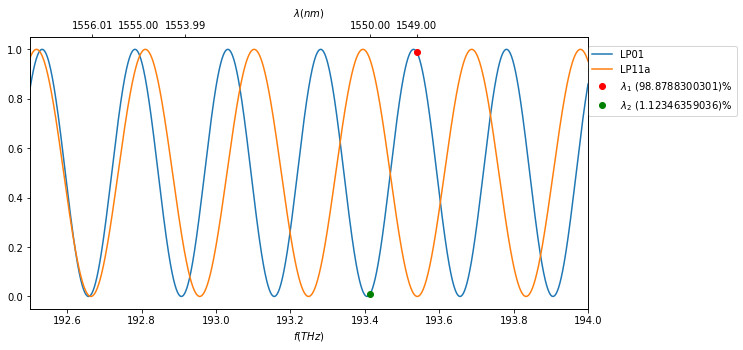

In [199]:
plot(fv,co_1,c2_1, l1, l2,f)

# WDM2:

In [200]:
co_2, c2_2 = get_req_dist_WDM(l3,l4, 'LP11')

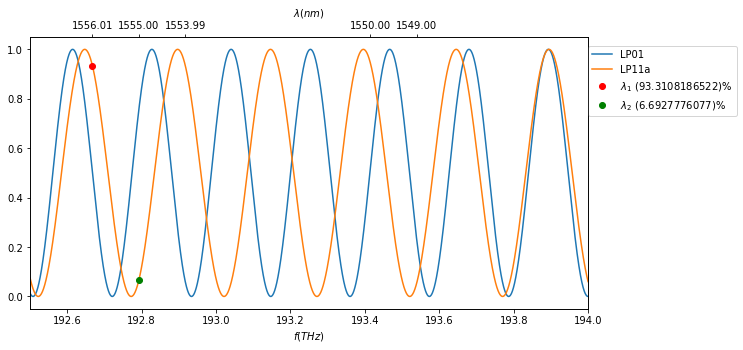

In [201]:
plot(fv,co_2,c2_2, l3,l4,f, 'LP11')

# Transmitance windows
(With no splice loss assumed)

In [202]:
def db(x):
    return 10*np.log10(x)
def perc(l):
    return 100*10**(l/10)
def trans(cwdm1,cwdm2):
    tot_t = []
    for i in range(2):
        clp = cwdm1[i],cwdm2[i] 
        tot_t.append(perc( db(np.abs(clp[0][1][0])**2) + db(np.abs(clp[1][0][0])**2)))
        #tot_t.append(perc(db(np.abs(clp[1][1][0])**2)))
    return tot_t
                 

In [203]:
def plot_fopo_trans(tot_t, fv, f, name = 'LP01'):
    if name== 'LP01':
        i,j = 0,0
    else:
        i,j = 1, 2
    wave_labels = [r'$\lambda_{p1}$',r'$\lambda_{s}$', 
                   r'$\lambda_{PC}$',r'$\lambda_{p2}$', r'$\lambda_{BS}$']
    f_pos = [np.argmin(abs(fv*1e-12 - fi)) for fi in f]
    fig = plt.figure(figsize = (10,5))
    ax1 = fig.add_subplot(111)
    ax1.set_xlim([192.5, 194])
    ax2 = ax1.twiny()
    p1 = ax1.plot(fv*1e-12, tot_t[i], label = name)
    ax1.plot([f[j+0]], tot_t[i][f_pos[j]], 'o', markersize=6, color="red", label = wave_labels[j])
    ax1.plot([f[j+1]], tot_t[i][f_pos[j +1]], 'o', markersize=6, color="green", label = wave_labels[j+1])
    if name == 'LP11':
        ax1.plot([f[j+2]], tot_t[i][f_pos[j +2]], 'o', markersize=6, color="black", label = wave_labels[j+2])
    ax1.set_xlabel(r'$f(THz)$')
    new_tick_locations = np.array(f[::-1])
    def tick_function(X):
        V = 1e-3*c/(X)
        return ["%.1f" % z for z in V]
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(tick_function(new_tick_locations))
    ax2.set_xlabel(r'$\lambda(nm)$')
    ax1.legend(loc = (1,0.5))
    plt.show()
    return None

In [204]:
tot_t = trans((co_1,co_2) , (co_2,c2_1) )

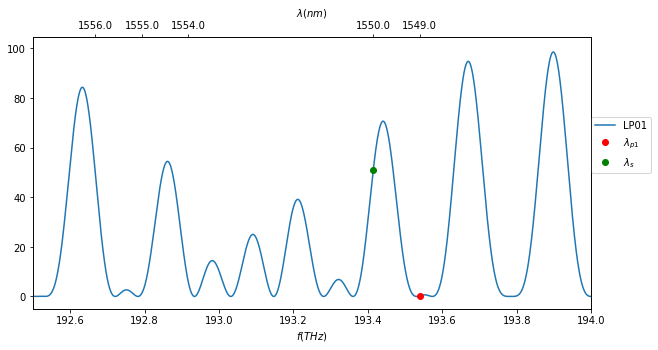

In [205]:
plot_fopo_trans(tot_t, fv, f)

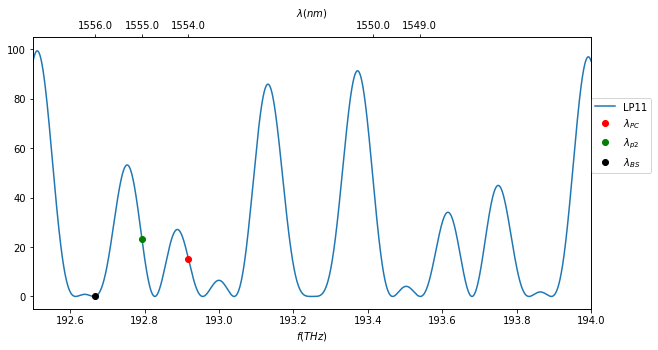

In [206]:
plot_fopo_trans(tot_t, fv, f, 'LP11')